In [2]:
import pandas as pd
import numpy as np
import os
import sys
from scipy.stats import zscore
import scipy.io

import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
fpath = f"../../data/raw_data/2018_tpm.csv"

df = pd.read_csv(fpath)
print(f"{df.shape=}")
df.head()

df.shape=(923280, 7)


,gene_name,time_id,tpm,time_point,replicate,hours,control
0,A1BG,D1_T1R1,0.126512,1,1,-48,control
1,A1BG,D1_T2R1,0.179995,2,1,0,timecourse
2,A1BG,D1_T3R1,0.068018,3,1,8,timecourse
3,A1BG,D2_T1R1,0.104575,1,1,16,timecourse
4,A1BG,D2_T2R1,0.196855,2,1,24,timecourse


In [22]:
gx = df[df['gene_name'] == 'MYOG']
gx = gx.groupby('hours')['tpm'].mean()
gx

hours
-48     0.000000
 0      0.000000
 8      0.000000
 16     0.000000
 24     0.013663
 32     0.011246
 40     0.064947
 48     0.011897
 56     0.000000
 64     0.157380
 72     0.210891
 80     0.042428
 88     0.973502
 96     0.092076
 104    0.433376
 112    0.560024
Name: tpm, dtype: float64

gene_name
MYOG     1.115859
PAX3     0.188388
SIX1     4.990806
SIX4    11.078803
Name: tpm, dtype: float64


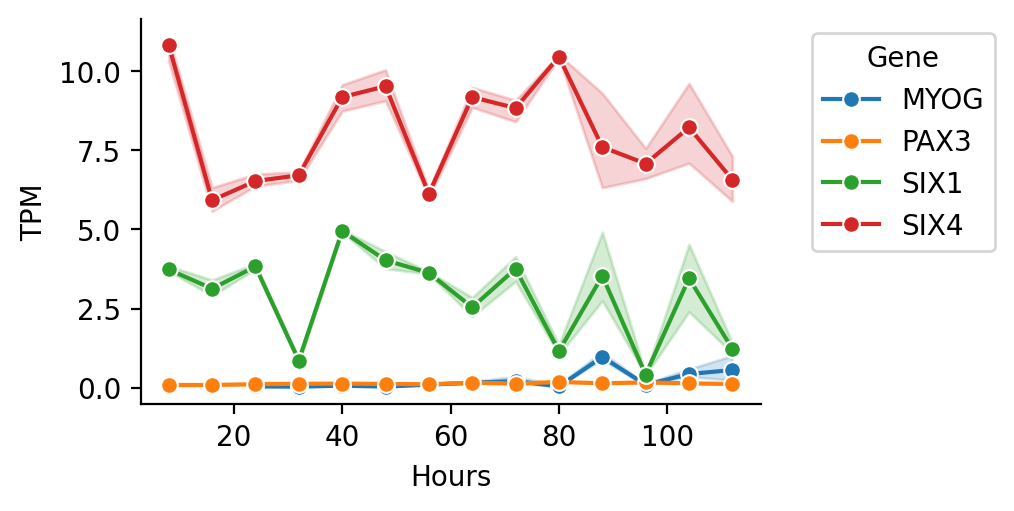

In [61]:
genes = [
    'Six1',
    'Six4',
    'Pax3',
    'Pax7',
    'Myf5',
    'Myod',
    'Myog',
    'Mrf4',
]

genes = [x.upper() for x in genes]
pdf = df[df['gene_name'].isin(genes)]
init = pdf[pdf['hours'] < 0]
pdf = pdf[pdf['hours'] > 0]
pdf = pdf[pdf['tpm'] > 0]

gx = pdf.groupby('gene_name')['tpm'].max()
print(gx)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 2.5

sns.lineplot(data=pdf,
             x='hours',
             y='tpm',
             marker='o',
             hue='gene_name')

plt.ylabel('TPM')
plt.xlabel('Hours')
sns.move_legend(plt.gca(), 
                loc='upper right',
                bbox_to_anchor=(1.4, 1),
                title='Gene')
sns.despine()

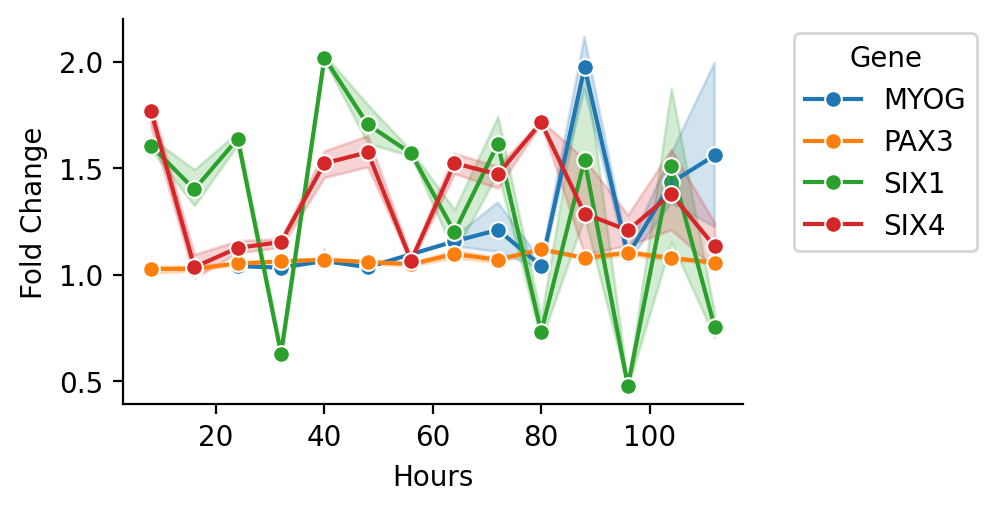

In [60]:
# get initial expression
X0 = init.groupby('gene_name')['tpm'].mean().to_dict()

# make fold change data
fc = pdf.copy()
fc['initial'] = fc['gene_name'].map(X0)
fc['fold_change'] = (fc['tpm'] + 1) / (fc['initial'] + 1)
fc = fc[fc['fold_change'] != 1.0]

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 2.5

sns.lineplot(data=fc,
             x='hours',
             y='fold_change',
             marker='o',
             hue='gene_name')

plt.ylabel('Fold Change')
plt.xlabel('Hours')
sns.move_legend(plt.gca(), 
                loc='upper right',
                bbox_to_anchor=(1.4, 1),
                title='Gene')
sns.despine()


In [15]:
def getGenes(pdf, cellType, ui_upper=None):
    genes = pdf[pdf['cell type'] == cellType]
    if not ui_upper is None:
        genes = genes[genes['ubiquitousness index'] < ui_upper]
    return genes['official gene symbol'].to_list()

pdfPath = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/panglaodb/pandb.tsv.gz"
pandDf = pd.read_csv(pdfPath, sep="\t")

# get myogenic genes
mg_cells = ['Myoblasts', 'Myofibroblasts', 'Myocytes']
myo = []

for mg in mg_cells:
    myo += getGenes(pandDf, mg)

myo = list(set(myo))
print(f"{len(myo)=}")

len(myo)=117


pdf['gene_name'].nunique()=115


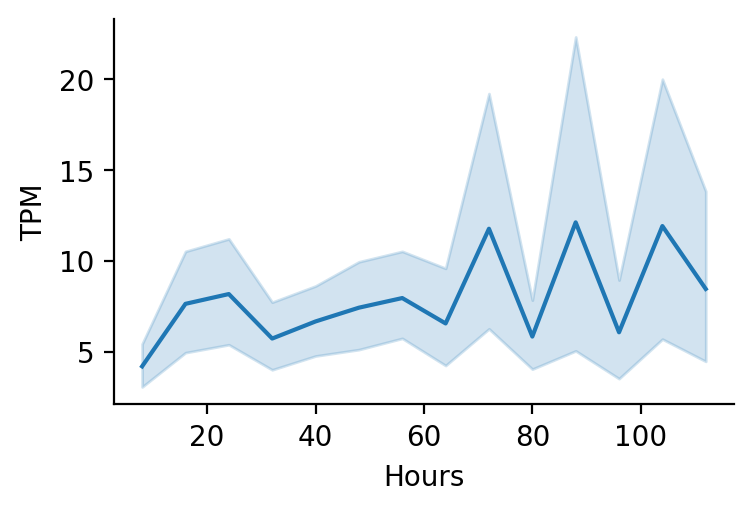

In [72]:
genes = [x.upper() for x in myo]
pdf = df[df['gene_name'].isin(myo)]
init = pdf[pdf['hours'] < 0]
pdf = pdf[pdf['hours'] > 0]

print(f"{pdf['gene_name'].nunique()=}")

sns.lineplot(data=pdf,
             x='hours',
             y='tpm')

plt.ylabel('TPM')
plt.xlabel('Hours')
sns.despine()

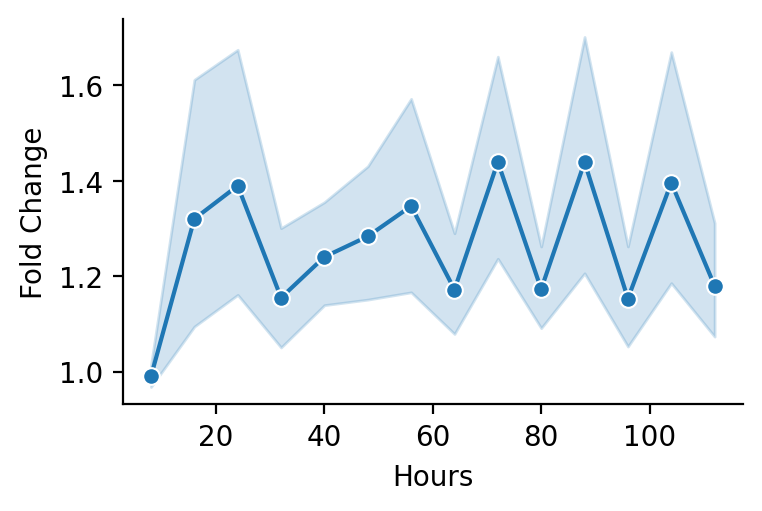

In [73]:
# get initial expression
X0 = init.groupby('gene_name')['tpm'].mean().to_dict()

# make fold change data
fc = pdf.copy()
fc['initial'] = fc['gene_name'].map(X0)
fc['fold_change'] = (fc['tpm'] + 1) / (fc['initial'] + 1)
fc = fc[fc['fold_change'] != 1.0]

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 2.5

sns.lineplot(data=fc,
             x='hours',
             y='fold_change',
             marker='o')

plt.ylabel('Fold Change')
plt.xlabel('Hours')
sns.despine()


In [71]:
gx = pdf.groupby('gene_name')['tpm'].mean()
gx = gx.sort_values(ascending=False)
gx = gx[gx > 0]

gx = pd.DataFrame(gx).reset_index(drop=False)
outpath = "../../data/surana_sensor_selection/2018_myogenic_expression.csv"

gx.to_csv(outpath, index=False)
print(gx.shape)

gx

(110, 2)


,gene_name,tpm
0,CXCL1,203.509080
1,CCL2,138.514860
2,TPM2,82.656393
3,ACTC1,78.329746
4,TAGLN,76.858293
...,...,...
105,ZBTB16,0.000874
106,MYH7,0.000611
107,NPHS1,0.000403
108,CHODL,0.000154
